In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [16]:
df = pd.read_csv("Harmful Algae Blooms in Bolinao (from HABhub) - Sheet1.csv")
print(df.shape)
print(df.info())
df.head()

(1929, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station_name      1929 non-null   object 
 1   embayment         1929 non-null   object 
 2   longitude         1929 non-null   float64
 3   latitude          1929 non-null   float64
 4   sample_date       1929 non-null   object 
 5   dissolved oxygen  1929 non-null   float64
 6   ph                1929 non-null   float64
 7   water temp        1929 non-null   float64
 8   time              1929 non-null   object 
 9   chlorophyll-a     1929 non-null   float64
dtypes: float64(6), object(4)
memory usage: 150.8+ KB
None


,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
0,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.5200,7.5755,28.8045,0:01:00,2.6136
1,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.0384,7.5566,28.7676,1:01:00,2.4442
2,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
3,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.1008,7.5566,28.7575,3:01:00,2.2264
4,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9424,7.6007,28.8213,4:01:00,2.4079


### Split
Let us split the data first to prevent any leakage

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
df_train.nunique()

station_name           1
embayment              1
longitude              1
latitude               1
sample_date           92
dissolved oxygen     868
ph                   244
water temp          1480
time                  24
chlorophyll-a        689
dtype: int64

In [19]:
cont_vars = df_train.nunique() != 1
filtered_df = df_train[df_train.columns[cont_vars]]
filtered_df = filtered_df.rename(columns={"chlorophyll-a": "chl", 
                                         "dissolved oxygen": "dissolved_oxygen",
                                         "water temp": "water_temp"})
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,time,chl
1352,2022-10-12,-2.6848,6.9140,30.6774,6:01:00,4.6948
141,2022-08-17,0.3344,7.5692,29.8578,2:01:00,3.4848
2,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
1190,2022-10-01,-0.7552,6.8762,30.2540,10:01:00,2.9645
1803,2023-10-02,1.1163,-0.2700,32.4355,15:01:00,1.6214
...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,22:01:00,2.9282
1294,2022-10-07,0.2960,6.8825,31.8933,19:01:00,7.3689
860,2022-09-17,-1.2544,6.8069,30.6729,13:01:00,4.5980
1459,2022-10-18,-2.6992,6.7754,29.7998,0:01:00,1.6335


In [20]:
filtered_df['sample_date'] = pd.to_datetime(filtered_df["sample_date"])
filtered_df['sample_date_int'] = filtered_df['sample_date'].astype("int64") / 10**11

filtered_df['time_hour'] = pd.to_datetime(filtered_df['time'], format="%H:%M:%S").dt.hour
filtered_df.drop(columns="time", inplace=True)

##### Note

* Converted `sample_date` to datetime format
* Added `sample_date_int` as a int varsion of the `sample_date` column
* Added `time_hour` to get only the Hour in time
* Removed the `time` column

Let us first do a simple Multiple Linear Regression to get a glimpse of everything

In [21]:
from statsmodels.formula.api import ols

formula = "chl ~ " + " + ".join([col for col in filtered_df.drop(columns="sample_date").columns  if col != "chl"])
lmlm = ols(formula, data=filtered_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sun, 04 May 2025   Prob (F-statistic):           5.07e-94
Time:                        10:24:54   Log-Likelihood:                -4385.5
No. Observations:                1543   AIC:                             8783.
Df Residuals:                    1537   BIC:                             8815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          718.6260     94.972      7.567      0.000     532.337     904.915
dissolved_oxygen     0.0799      0.036      2.226      0.026       0.009       0.150
ph                  -1.4007      0.278     -5.047      0.000      -1.945      -0.856
water_temp           1.9163      0.106     18.070      0.000       1.708       2.124
sample_date_int  -4.583e-05    5.6e-06     -8.184      0.000   -5.68e-05   -3.48e-05
time_hour            0.0729      0.016      4.573      0.000       0.042       0.104
==============================================================================
Omnibus:                     1067.235   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17136.045
Skew:                           3.060   Prob(JB):                         0.00
Kurtosis:                      18.135   Cond. No.                     1.49e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All are significant except the `dissolved_oxygen` which could be problematic given that we need that column!

In [22]:
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
1352,2022-10-12,-2.6848,6.9140,30.6774,4.6948,16655328.0,6
141,2022-08-17,0.3344,7.5692,29.8578,3.4848,16606944.0,2
2,2022-08-11,-0.9472,7.5881,28.7926,2.6257,16601760.0,2
1190,2022-10-01,-0.7552,6.8762,30.2540,2.9645,16645824.0,10
1803,2023-10-02,1.1163,-0.2700,32.4355,1.6214,16962048.0,15
...,...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,2.9282,16643232.0,22
1294,2022-10-07,0.2960,6.8825,31.8933,7.3689,16651008.0,19
860,2022-09-17,-1.2544,6.8069,30.6729,4.5980,16633728.0,13
1459,2022-10-18,-2.6992,6.7754,29.7998,1.6335,16660512.0,0


## EDA

#### Missing Values

In [23]:
filtered_df.isna().sum()

sample_date         0
dissolved_oxygen    0
ph                  0
water_temp          0
chl                 0
sample_date_int     0
time_hour           0
dtype: int64

#### Distribution

Text(0.5, 1.0, 'Distribution of Columns')

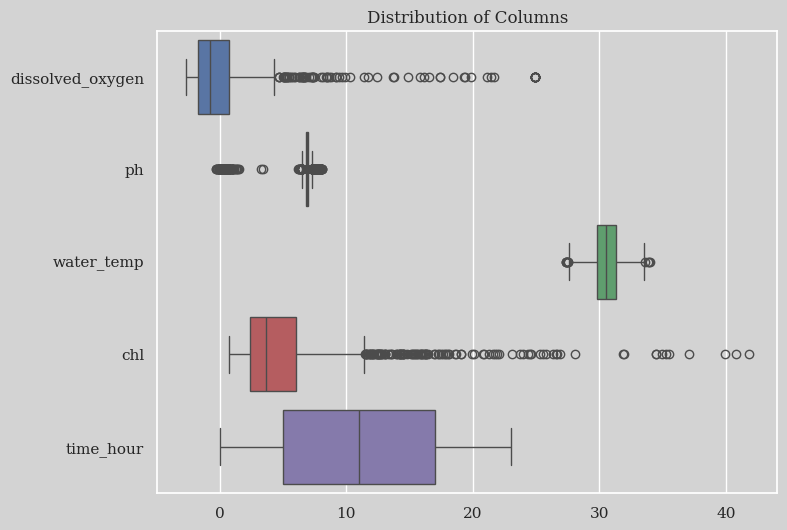

In [24]:
plt.figure(figsize=(8, 6))

sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

sns.boxplot(filtered_df.drop(columns=["sample_date", 'sample_date_int']), orient="h")
plt.title("Distribution of Columns")

Lots of outliers in all of columns with exception of `time_hour`

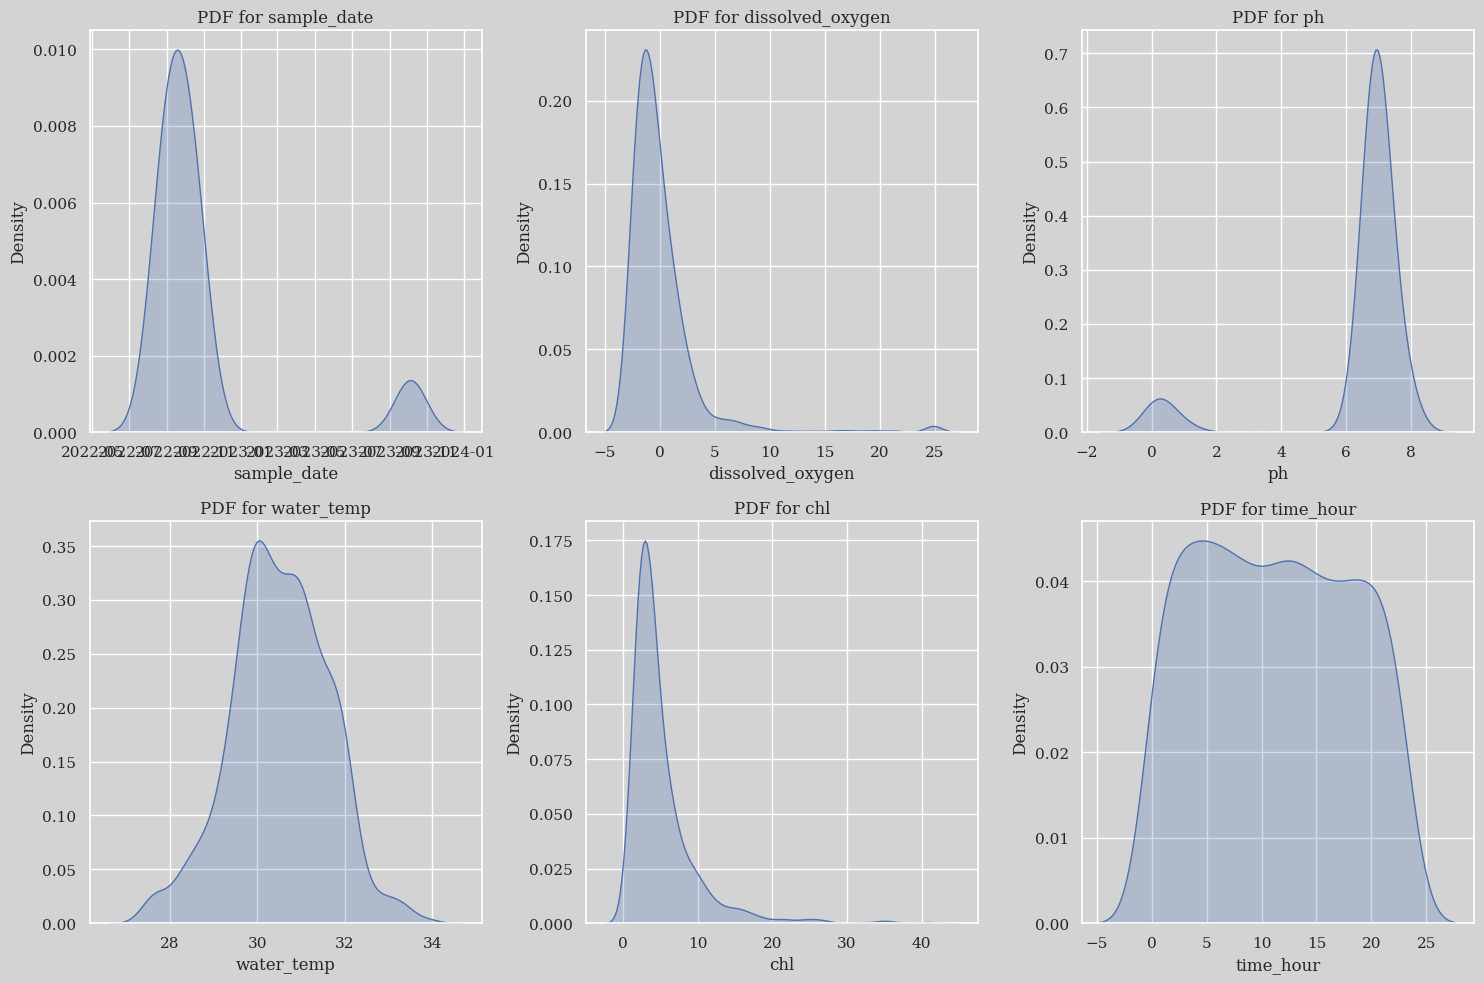

In [25]:

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = filtered_df.drop(columns=['sample_date_int']).columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(filtered_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col}")

plt.tight_layout()

Well it appears that all of our columns are skewed! With the exceptions of `water_temp` and `time_hour`.

This isn't usually an issue in a linear regression model but given that we also got significant amount of outliers for each of those skewed data, a transformation is in order. With transformation, we can reduce the outliers and normalize the data which is beneficial for our linear model.

Let's look at the range before proceeding.

In [33]:
mask = filtered_df['ph'] > 4

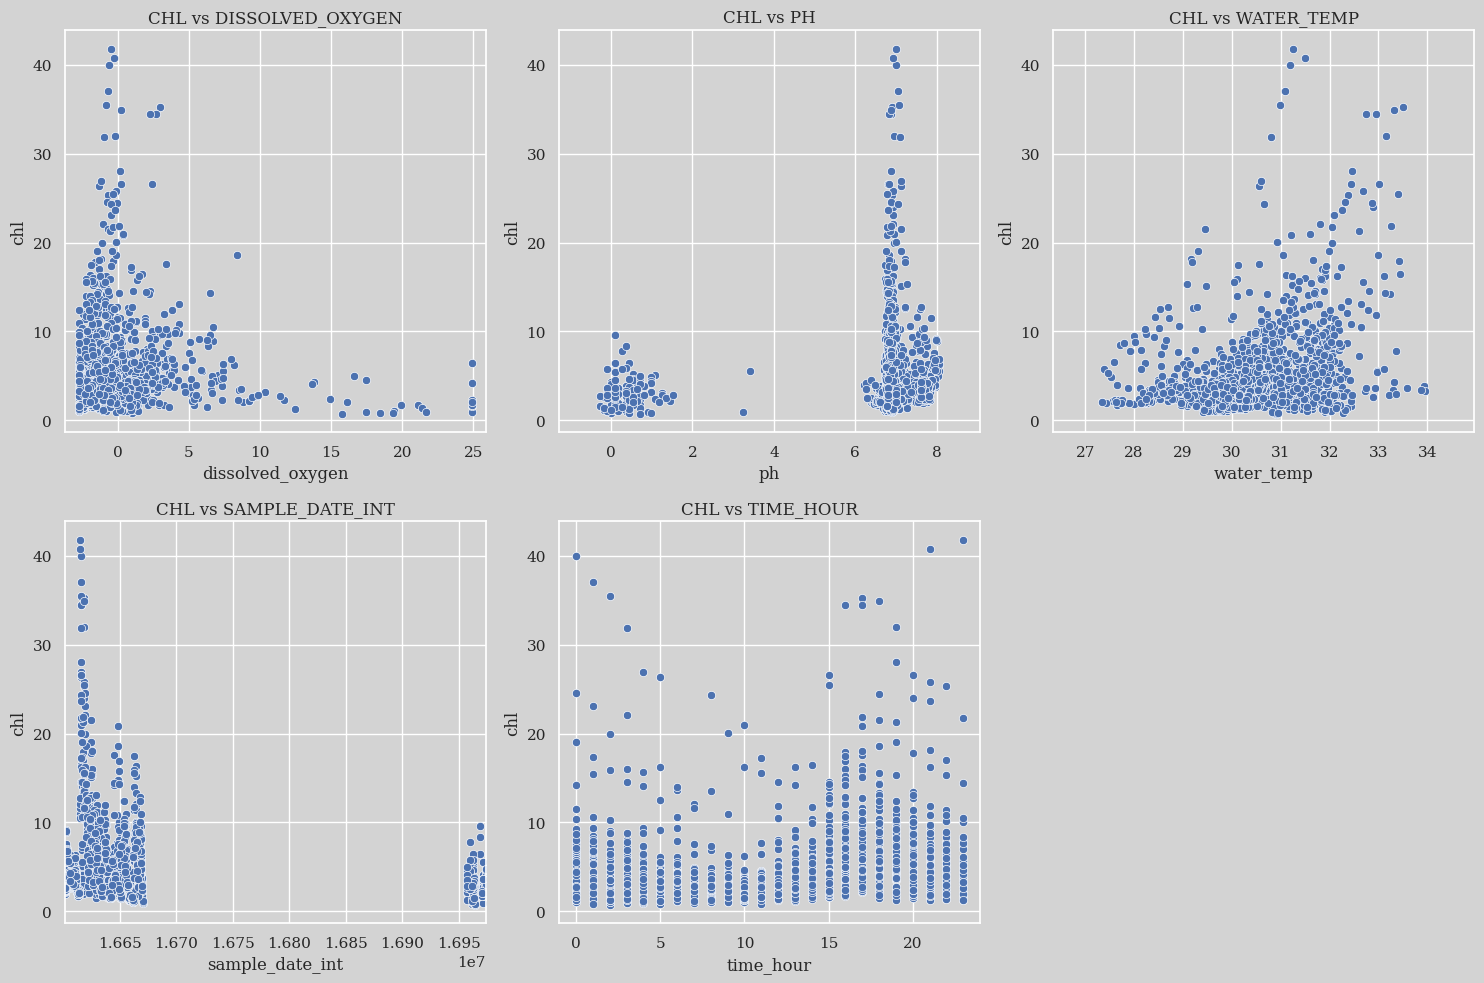

In [31]:
cols = filtered_df.drop(columns=['chl', 'sample_date']).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=filtered_df,
        x=col,
        y="chl",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL vs {col.upper()}")
    ax[ind].set_xlim(min(filtered_df[col]) -1 , max(filtered_df[col]) +1)
plt.delaxes(ax[-1])
plt.tight_layout()

In [27]:
filtered_df["ph"].describe()

count    1543.000000
mean        6.406682
std         1.921613
min        -0.270000
25%         6.813200
50%         6.895100
75%         6.995900
max         8.060600
Name: ph, dtype: float64

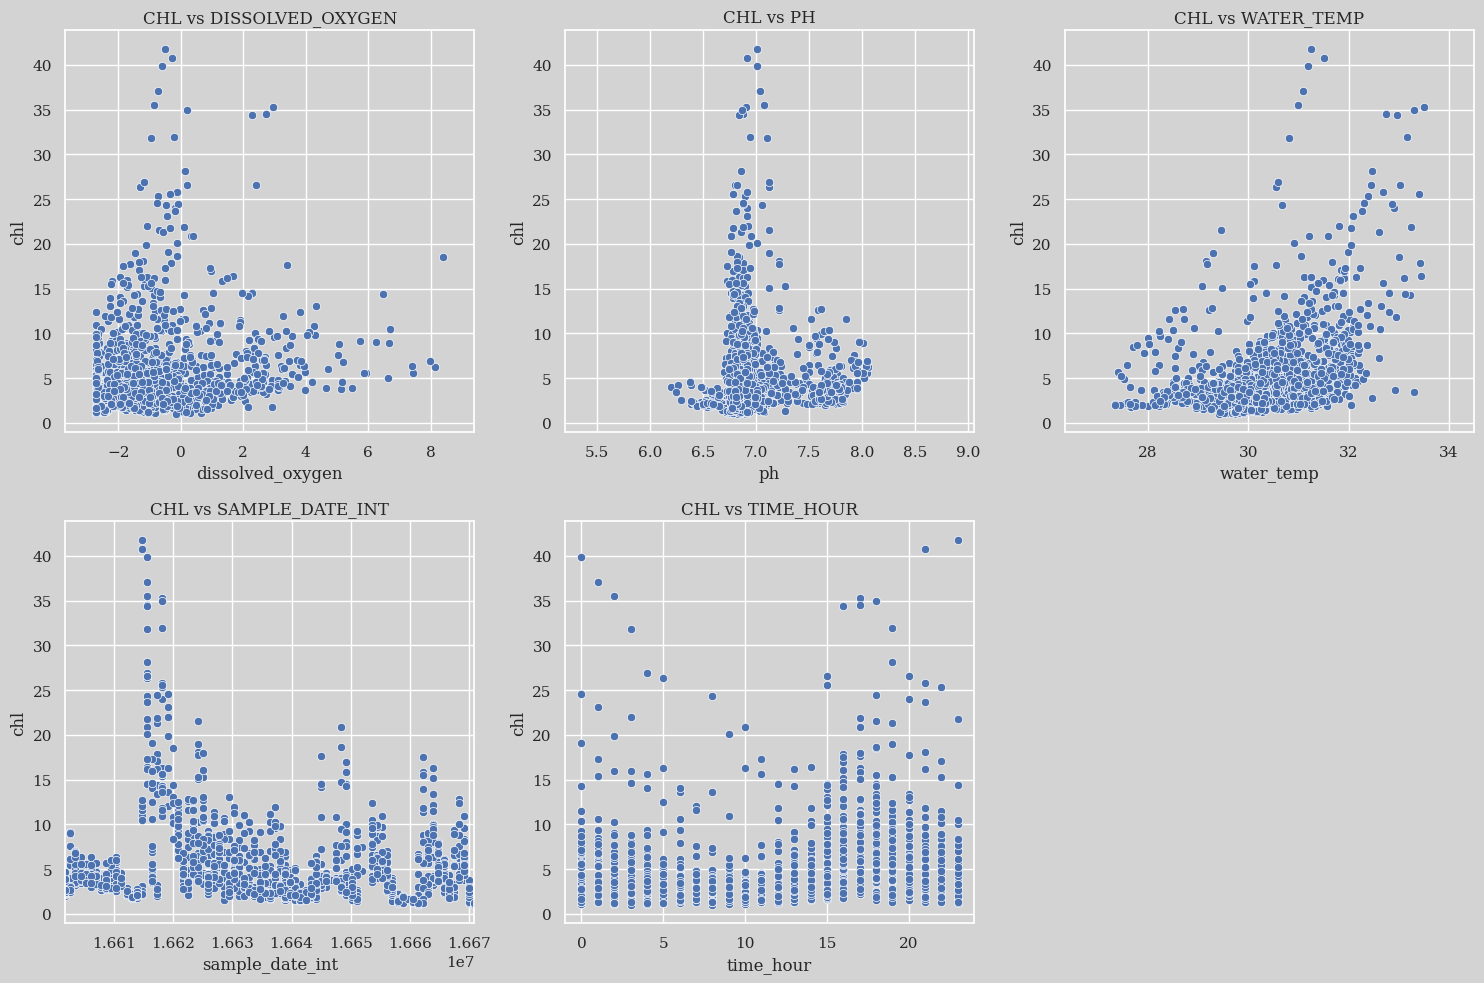

In [34]:
cols = filtered_df.drop(columns=['chl', 'sample_date']).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=filtered_df[mask],
        x=col,
        y="chl",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL vs {col.upper()}")
    ax[ind].set_xlim(min(filtered_df[mask][col]) -1 , max(filtered_df[mask][col]) +1)
plt.delaxes(ax[-1])
plt.tight_layout()

In [ ]:
df_filter = filtered_df[mask].copy()

In [37]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")

pt.fit(filtered_df[mask][['chl']])

df_filter['chl_yeo'] =  pt.transform(filtered_df[mask][['chl']]).squeeze()

<Axes: xlabel='dissolved_oxygen', ylabel='chl_yeo'>

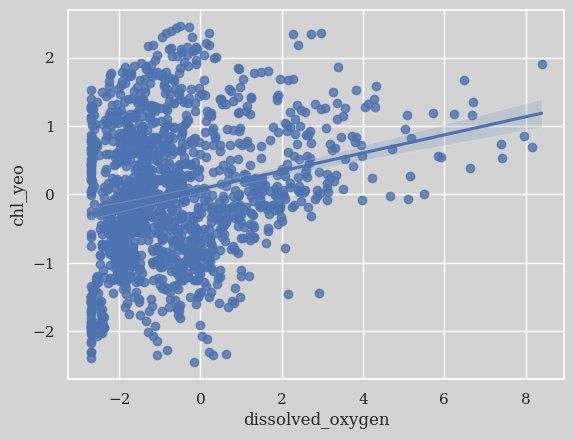

In [38]:
constant = abs(np.min(filtered_df[mask]['dissolved_oxygen'])) + 1

df_filter['log_do'] = np.log(filtered_df[mask]['dissolved_oxygen'] + constant)

sns.regplot(
    df_filter,
    x='dissolved_oxygen',
    y='chl_yeo'
)

In [ ]:
len(cols)/3

2.6666666666666665

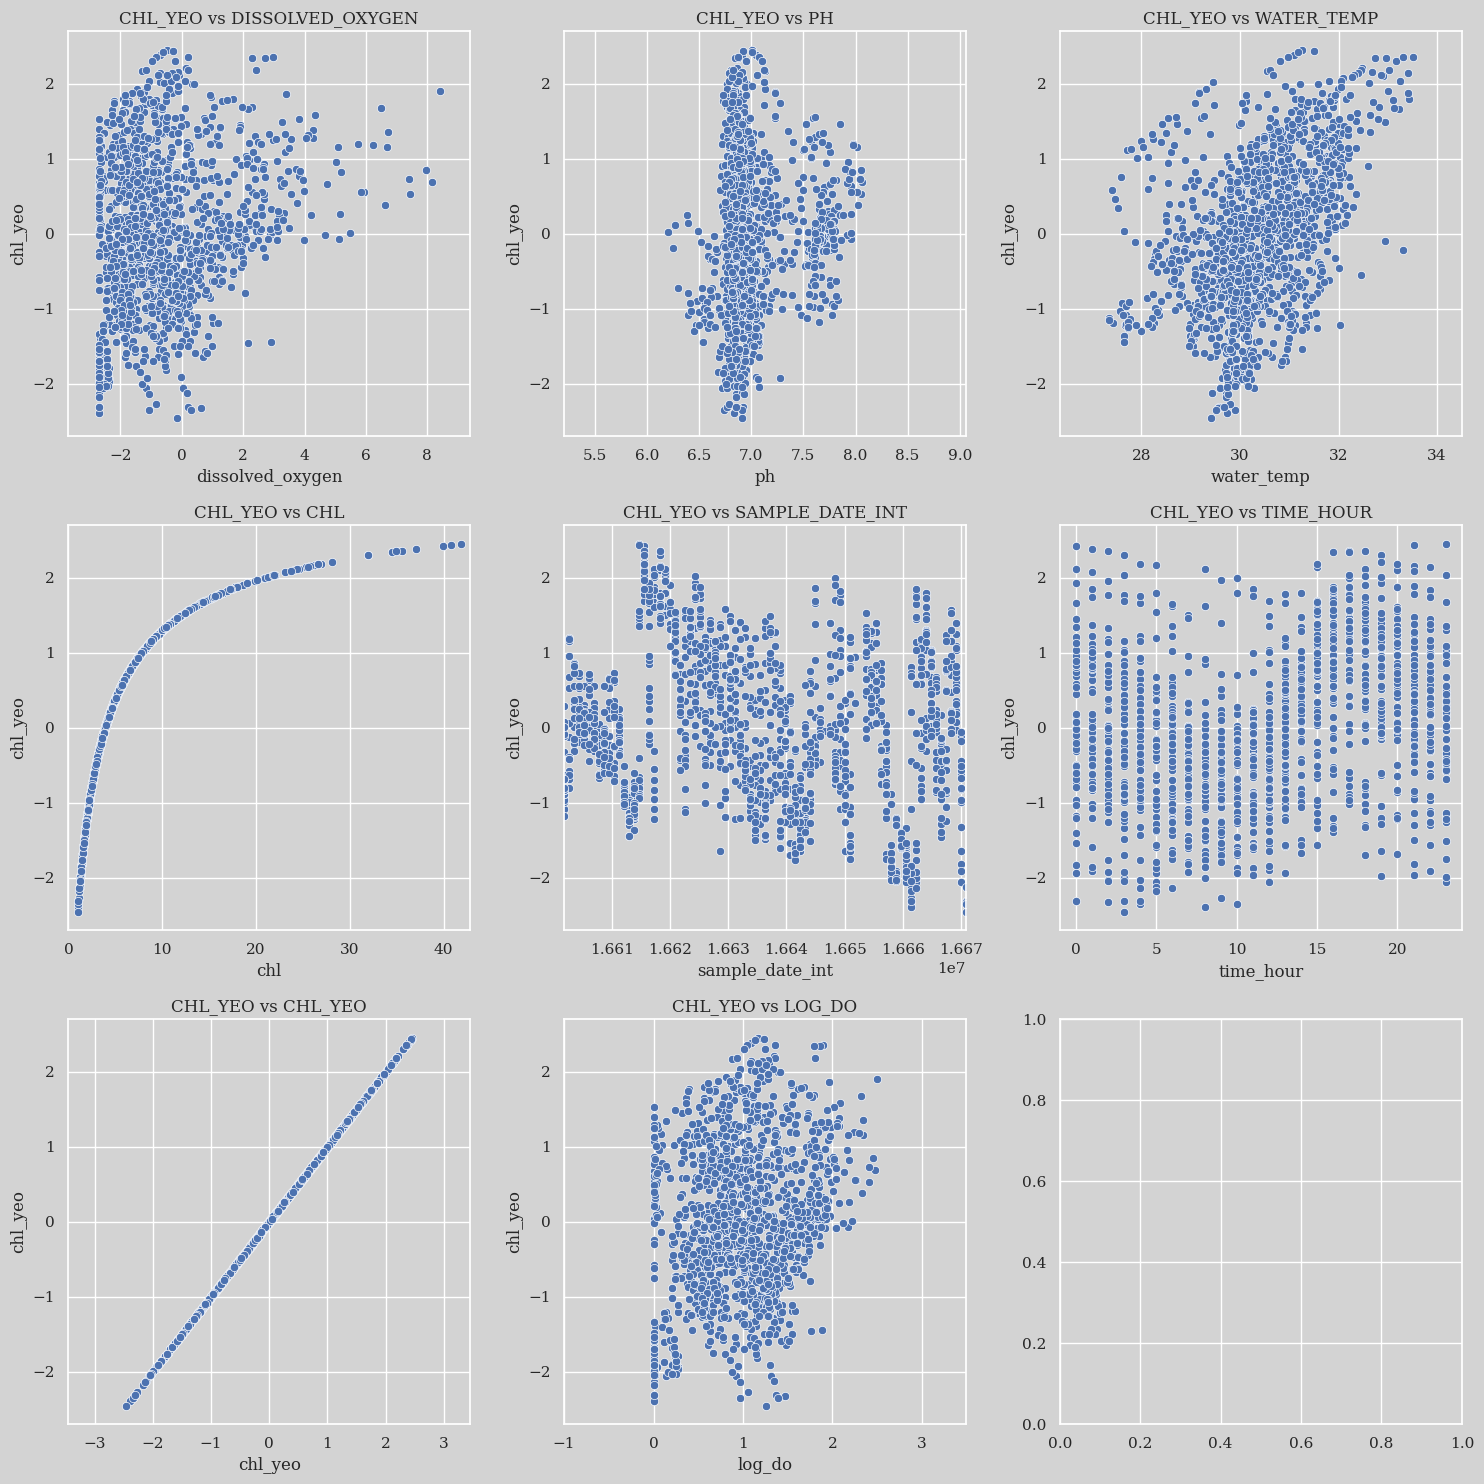

In [ ]:
cols = df_filter.drop(columns="sample_date").columns
rows = int(np.ceil(len(cols)/3))
fig, ax = plt.subplots(ncols=3, nrows=rows, figsize=(15,5 * rows))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=df_filter,
        x=col,
        y="chl_yeo",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL_YEO vs {col.upper()}")
    ax[ind].set_xlim(min(df_filter[col]) -1 , max(df_filter[col]) +1)
plt.tight_layout()

#### PH

In [68]:
formula = "chl_yeo ~ ph"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.309
Date:                Sun, 04 May 2025   Prob (F-statistic):            0.00232
Time:                        10:47:26   Log-Likelihood:                -1987.5
No. Observations:                1404   AIC:                             3979.
Df Residuals:                    1402   BIC:                             3990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8849      0.618     -3.048      0.002      -3.098      -0.672
ph             0.2692      0.088      3.051      0.002       0.096       0.442
==============================================================================
Omnibus:                       33.963   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.131
Skew:                           0.129   Prob(JB):                     4.25e-05
Kurtosis:                       2.474   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
formula = "chl_yeo ~ bs(ph, df=5)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.568
Date:                Sun, 04 May 2025   Prob (F-statistic):           5.03e-07
Time:                        10:52:07   Log-Likelihood:                -1973.4
No. Observations:                1404   AIC:                             3959.
Df Residuals:                    1398   BIC:                             3990.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5294      0.620      0.854      0.393      -0.686       1.745
bs(ph, df=5)[0]    -2.9260      0.983     -2.978      0.003      -4.853      -0.999
bs(ph, df=5)[1]    -0.2219      0.597     -0.372      0.710      -1.393       0.949
bs(ph, df=5)[2]    -0.8548      0.690     -1.239      0.216      -2.209       0.499
bs(ph, df=5)[3]    -0.4668      0.661     -0.706      0.480      -1.763       0.829
bs(ph, df=5)[4]     0.0120      0.698      0.017      0.986      -1.357       1.381
==============================================================================
Omnibus:                       21.456   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.460
Skew:                           0.075   Prob(JB):                      0.00119
Kurtosis:                       2.544   Cond. No.                         74.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Sample Date Int

In [65]:
formula = "chl_yeo ~ sample_date_int"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     45.69
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.02e-11
Time:                        10:43:55   Log-Likelihood:                -1969.7
No. Observations:                1404   AIC:                             3943.
Df Residuals:                    1402   BIC:                             3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         146.7189     21.705      6.760      0.000     104.140     189.297
sample_date_int  -8.82e-06    1.3e-06     -6.760      0.000   -1.14e-05   -6.26e-06
==============================================================================
Omnibus:                      120.488   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.977
Skew:                           0.155   Prob(JB):                     4.65e-10
Kurtosis:                       2.201   Cond. No.                     1.37e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
formula = "chl_yeo ~ sample_date_int + np.power(sample_date_int, 2) + np.power(sample_date_int, 3) +  np.power(sample_date_int, 4)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     45.81
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.91e-11
Time:                        10:44:38   Log-Likelihood:                -1969.6
No. Observations:                1404   AIC:                             3943.
Df Residuals:                    1402   BIC:                             3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     2.772e-41   4.09e-42      6.768      0.000    1.97e-41    3.57e-41
sample_date_int              -7.336e-28   1.08e-28     -6.768      0.000   -9.46e-28   -5.21e-28
np.power(sample_date_int, 2)  3.835e-27   5.67e-28      6.768      0.000    2.72e-27    4.95e-27
np.power(sample_date_int, 3)   3.19e-20   4.71e-21      6.768      0.000    2.27e-20    4.11e-20
np.power(sample_date_int, 4) -1.918e-27   2.83e-28     -6.769      0.000   -2.47e-27   -1.36e-27
==============================================================================
Omnibus:                      120.667   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.015
Skew:                           0.155   Prob(JB):                     4.56e-10
Kurtosis:                       2.201   Cond. No.                     8.87e+40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.05e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Water Tempt

In [60]:
formula = "chl_yeo ~ water_temp"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     376.7
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.62e-74
Time:                        10:38:35   Log-Likelihood:                -1825.1
No. Observations:                1404   AIC:                             3654.
Df Residuals:                    1402   BIC:                             3665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.1802      0.679    -19.398      0.000     -14.513     -11.847
water_temp     0.4338      0.022     19.409      0.000       0.390       0.478
==============================================================================
Omnibus:                        1.772   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.741
Skew:                           0.038   Prob(JB):                        0.419
Kurtosis:                       2.845   Cond. No.                         872.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
temp_trans = PowerTransformer()
temp_trans.fit(df_filter[['water_temp']])

df_filter['water_temp_yeo'] =temp_trans.transform(df_filter[['water_temp']])

In [63]:
formula = "chl_yeo ~ water_temp_yeo"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     388.3
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.69e-76
Time:                        10:40:40   Log-Likelihood:                -1820.6
No. Observations:                1404   AIC:                             3645.
Df Residuals:                    1402   BIC:                             3656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.966e-16      0.024  -1.26e-14      1.000      -0.046       0.046
water_temp_yeo     0.4657      0.024     19.706      0.000       0.419       0.512
==============================================================================
Omnibus:                        1.655   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.647
Skew:                           0.040   Prob(JB):                        0.439
Kurtosis:                       2.852   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Dissolved Oxygen

In [39]:
formula = "chl_yeo ~ dissolved_oxygen"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     75.63
Date:                Sun, 04 May 2025   Prob (F-statistic):           9.38e-18
Time:                        10:27:19   Log-Likelihood:                -1955.3
No. Observations:                1404   AIC:                             3915.
Df Residuals:                    1402   BIC:                             3925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0786      0.028      2.854      0.004       0.025       0.133
dissolved_oxygen     0.1320      0.015      8.697      0.000       0.102       0.162
==============================================================================
Omnibus:                       40.410   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.011
Skew:                           0.183   Prob(JB):                     3.71e-06
Kurtosis:                       2.458   Cond. No.                         2.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
filtered_df.aggregate(["min", "max"])

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
min,2022-08-11,-2.6992,-0.2700,27.3432,0.7018,16601760.0,0
max,2023-10-16,24.8880,8.0606,33.9583,41.8297,16974144.0,23


So we can't do log transformation because `dissolved_oxygen` and `ph` has negative values.

Let's try "Yeo-Jhonson" since it can handle negative values.

In [ ]:
filtered_df_fix = pd.DataFrame([transformed_data, chl_trans], index=['log_do', 'chl_yeo']).T

#### Time Hour

In [58]:
formula = "chl_yeo ~ time_hour"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     116.6
Date:                Sun, 04 May 2025   Prob (F-statistic):           3.58e-26
Time:                        10:36:54   Log-Likelihood:                -1936.1
No. Observations:                1404   AIC:                             3876.
Df Residuals:                    1402   BIC:                             3887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4571      0.049     -9.235      0.000      -0.554      -0.360
time_hour      0.0403      0.004     10.800      0.000       0.033       0.048
==============================================================================
Omnibus:                        7.930   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.263
Skew:                           0.064   Prob(JB):                       0.0436
Kurtosis:                       2.699   Cond. No.                         25.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
formula = "chl_yeo ~ time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     87.96
Date:                Sun, 04 May 2025   Prob (F-statistic):           9.94e-67
Time:                        10:34:41   Log-Likelihood:                -1834.7
No. Observations:                1404   AIC:                             3679.
Df Residuals:                    1399   BIC:                             3706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1101      0.095      1.161      0.246      -0.076       0.296
time_hour                 -0.0710      0.059     -1.195      0.232      -0.188       0.046
np.power(time_hour, 2)    -0.0219      0.011     -2.011      0.045      -0.043      -0.001
np.power(time_hour, 3)     0.0033      0.001      4.557      0.000       0.002       0.005
np.power(time_hour, 4) -9.715e-05   1.57e-05     -6.204      0.000      -0.000   -6.64e-05
==============================================================================
Omnibus:                        1.368   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                1.277
Skew:                          -0.034   Prob(JB):                        0.528
Kurtosis:                       3.131   Cond. No.                     4.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Final Model (?)

In [79]:
formula = "chl_yeo ~ dissolved_oxygen + water_temp + time_hour + ph"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     138.3
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.13e-99
Time:                        10:54:28   Log-Likelihood:                -1758.2
No. Observations:                1404   AIC:                             3526.
Df Residuals:                    1399   BIC:                             3553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -16.6556      1.069    -15.579      0.000     -18.753     -14.558
dissolved_oxygen     0.0348      0.016      2.217      0.027       0.004       0.066
water_temp           0.4190      0.023     18.257      0.000       0.374       0.464
time_hour            0.0276      0.003      8.121      0.000       0.021       0.034
ph                   0.5186      0.090      5.791      0.000       0.343       0.694
==============================================================================
Omnibus:                        8.464   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.068
Skew:                           0.098   Prob(JB):                       0.0292
Kurtosis:                       2.713   Cond. No.                     1.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
formula = "chl_yeo ~ dissolved_oxygen + water_temp + time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4) + bs(ph, df=5)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     86.26
Date:                Sun, 04 May 2025   Prob (F-statistic):          1.61e-148
Time:                        11:03:07   Log-Likelihood:                -1627.3
No. Observations:                1404   AIC:                             3279.
Df Residuals:                    1392   BIC:                             3342.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -13.0495      0.881    -14.806      0.000     -14.779     -11.321
dissolved_oxygen           0.0523      0.015      3.420      0.001       0.022       0.082
water_temp                 0.4423      0.024     18.737      0.000       0.396       0.489
time_hour                 -0.0158      0.052     -0.302      0.763      -0.118       0.087
np.power(time_hour, 2)    -0.0288      0.010     -3.012      0.003      -0.048      -0.010
np.power(time_hour, 3)     0.0035      0.001      5.511      0.000       0.002       0.005
np.power(time_hour, 4) -9.641e-05   1.36e-05     -7.083      0.000      -0.000   -6.97e-05
bs(ph, df=5)[0]            0.0603      0.781      0.077      0.938      -1.471       1.592
bs(ph, df=5)[1]           -0.9755      0.468     -2.083      0.037      -1.894      -0.057
bs(ph, df=5)[2]            0.6947      0.547      1.271      0.204      -0.378       1.767
bs(ph, df=5)[3]            0.6342      0.520      1.220      0.223      -0.386       1.654
bs(ph, df=5)[4]           -1.0210      0.562     -1.816      0.070      -2.124       0.082
==============================================================================
Omnibus:                        3.556   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.212
Skew:                           0.053   Prob(JB):                        0.201
Kurtosis:                       2.791   Cond. No.                     6.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
np.round(df_filter_std.agg(["mean", "std"]), 2)

,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour,log_do,water_temp_yeo,chl_yeo
mean,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.10
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.93


In [89]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
drop_col = ["chl_yeo", "sample_date"]
std.fit(df_filter.drop(columns=drop_col))

X_trans = std.transform(df_filter.drop(columns=drop_col))

df_filter_std = pd.DataFrame(X_trans, columns=df_filter.drop(columns=drop_col).columns)

df_filter_std['chl_yeo'] = df_filter['chl_yeo']

In [90]:
formula = "chl_yeo ~ dissolved_oxygen + water_temp + time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4) + bs(ph, df=5)"
lmlm = ols(formula, data=df_filter_std)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7848
Date:                Sun, 04 May 2025   Prob (F-statistic):              0.656
Time:                        11:01:31   Log-Likelihood:                -1518.4
No. Observations:                1133   AIC:                             3061.
Df Residuals:                    1121   BIC:                             3121.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1648      0.595      0.277      0.782      -1.002       1.332
dissolved_oxygen           0.0165      0.036      0.459      0.646      -0.054       0.087
water_temp                -0.0535      0.033     -1.615      0.107      -0.119       0.012
time_hour                  0.0190      0.076      0.251      0.802      -0.130       0.168
np.power(time_hour, 2)    -0.2046      0.109     -1.871      0.062      -0.419       0.010
np.power(time_hour, 3)    -0.0135      0.037     -0.363      0.716      -0.086       0.059
np.power(time_hour, 4)     0.0630      0.040      1.563      0.118      -0.016       0.142
bs(ph, df=5)[0]           -0.1910      0.987     -0.194      0.847      -2.127       1.745
bs(ph, df=5)[1]            0.1765      0.574      0.307      0.759      -0.950       1.303
bs(ph, df=5)[2]           -0.2081      0.676     -0.308      0.758      -1.535       1.119
bs(ph, df=5)[3]            0.2422      0.651      0.372      0.710      -1.034       1.519
bs(ph, df=5)[4]           -0.1347      0.713     -0.189      0.850      -1.533       1.264
==============================================================================
Omnibus:                       49.631   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.355
Skew:                           0.325   Prob(JB):                     2.10e-08
Kurtosis:                       2.430   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
from sklearn.preprocessing import PowerTransformer
cols = filtered_df[mask].drop(columns="sample_date").columns.to_list()

pt = PowerTransformer(method="yeo-johnson")

pt.fit(filtered_df.drop(columns="sample_date")[mask])

new_data = pt.transform(filtered_df.drop(columns="sample_date")[mask])

new_df = pd.DataFrame(new_data, columns=cols, index=filtered_df[mask].index)

<Axes: >

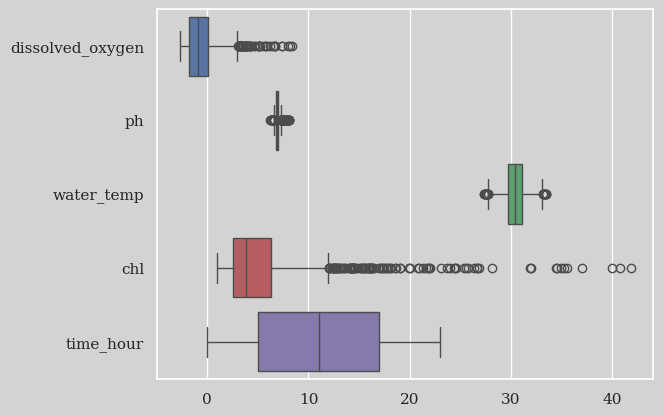

In [ ]:
sns.boxplot(filtered_df.drop(columns=['sample_date_int'])[mask], orient="h")

<Axes: xlabel='sample_date_int'>

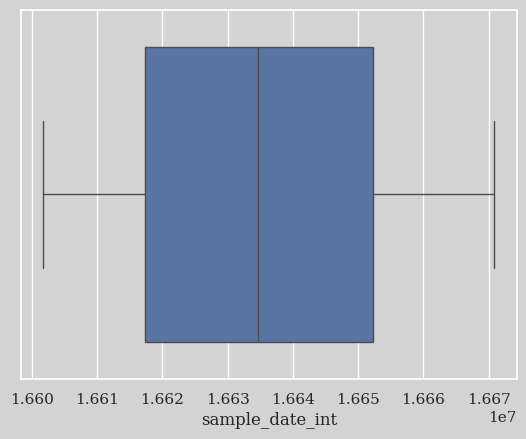

In [ ]:
sns.boxplot(filtered_df[mask]['sample_date_int'], orient="h")

No need to transform time_hour and date_int

I have an idea. I might want to create a cap for the ph to control the outliers. Then create new features that will determine the magnitude in which it deviate from the cap. Then I can just winsorize the ph itself. 

<Axes: xlabel='ph'>

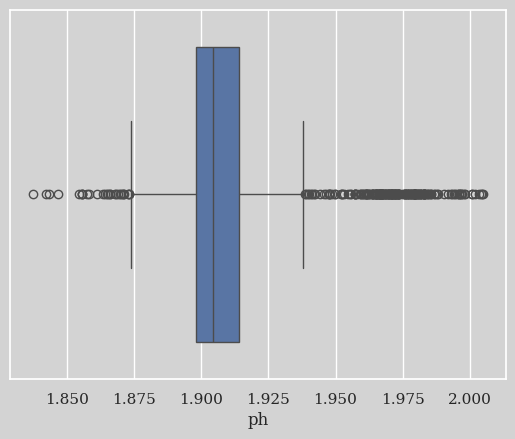

In [ ]:
date = filtered_df[mask]['ph']

sns.boxplot(date**(1/3), orient="h")

<Axes: xlabel='ph'>

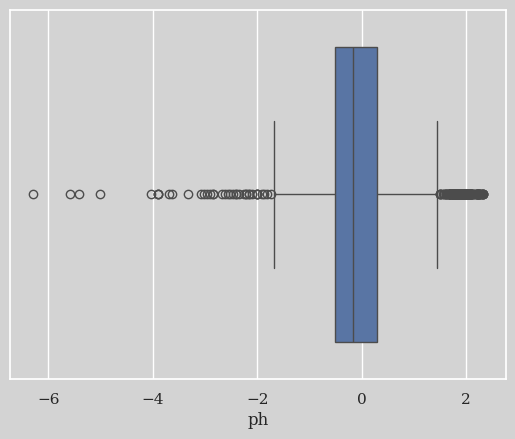

In [ ]:
sns.boxplot(new_df['ph'], orient="h")

<Axes: xlabel='ph', ylabel='chl_yeo'>

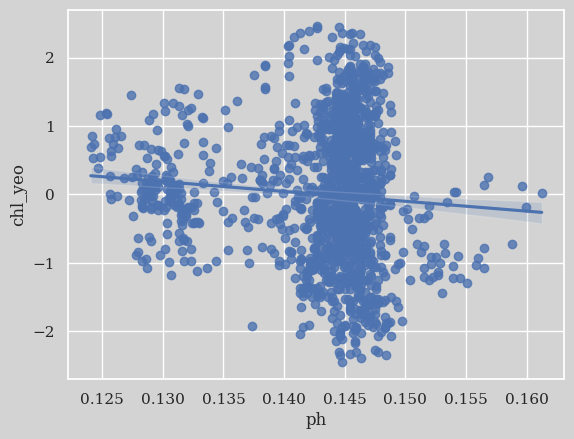

In [ ]:
sns.regplot(
    x=1/filtered_df[mask]['ph'],
    y=df_filter['chl_yeo']
)

<Axes: ylabel='Density'>

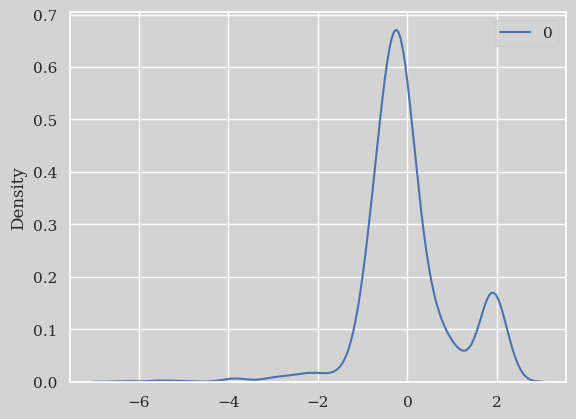

In [ ]:
eto_ah =PowerTransformer(method="box-cox")

eto_ah.fit(filtered_df[mask][['ph']])

transformed_data = eto_ah.transform(filtered_df[mask][['ph']])

sns.kdeplot(transformed_data)

<Axes: >

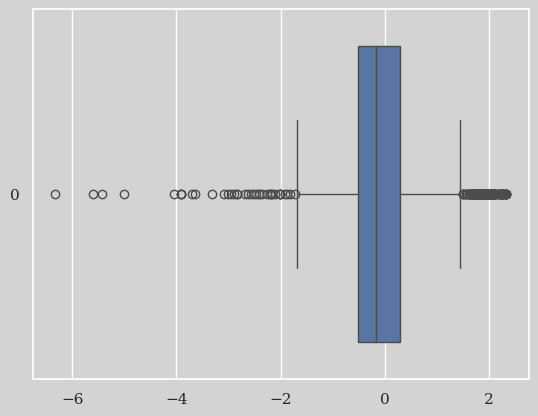

In [ ]:
sns.boxplot(transformed_data, orient="h")

In [ ]:
lower, upper = np.quantile(transformed_data, [0.25, 0.75])

array([-0.50717016,  0.28339521])

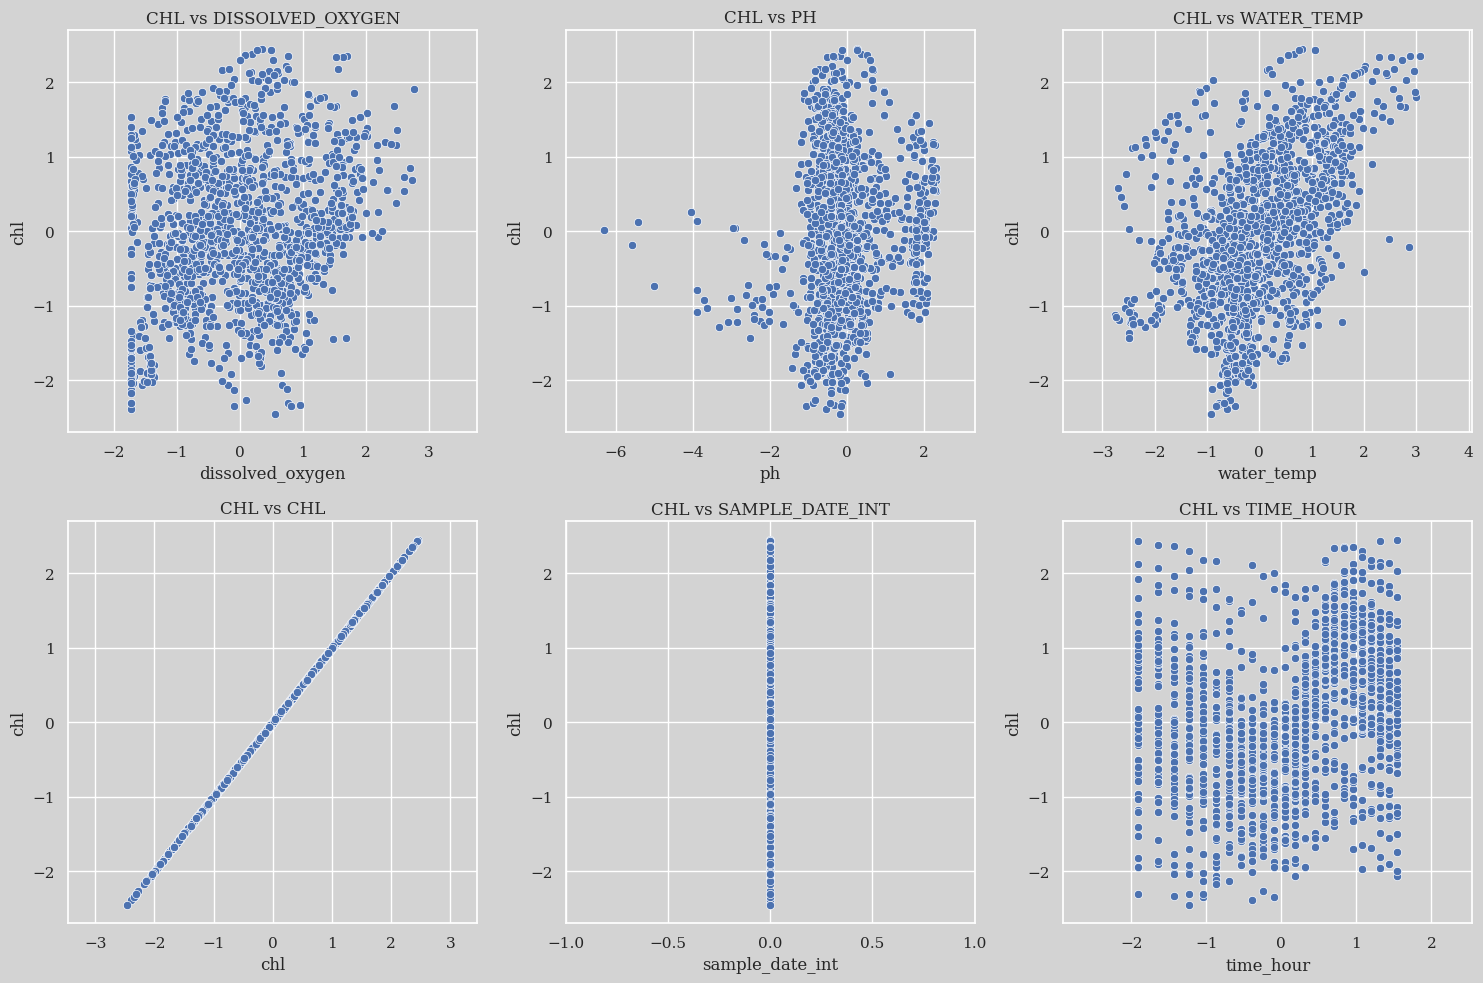

In [ ]:
cols = new_df.columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=new_df,
        x=col,
        y="chl",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL vs {col.upper()}")
    ax[ind].set_xlim(min(new_df[col]) -1 , max(new_df[col]) +1)
# plt.delaxes(ax[-1])
plt.tight_layout()

In [44]:
formula = "chl ~ " + " + ".join([col for col in new_df.columns  if col != "chl"])
lmlm = ols(formula, data=new_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     128.7
Date:                Sun, 04 May 2025   Prob (F-statistic):          2.73e-112
Time:                        10:29:30   Log-Likelihood:                -1726.4
No. Observations:                1404   AIC:                             3465.
Df Residuals:                    1398   BIC:                             3496.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.38e-05      0.022     -0.001      1.000      -0.043       0.043
dissolved_oxygen     0.0321      0.026      1.239      0.216      -0.019       0.083
ph                   0.0959      0.025      3.762      0.000       0.046       0.146
water_temp           0.4737      0.023     20.229      0.000       0.428       0.520
sample_date_int  -5.853e+12   7.54e+11     -7.767      0.000   -7.33e+12   -4.37e+12
time_hour            0.1673      0.023      7.306      0.000       0.122       0.212
==============================================================================
Omnibus:                       19.274   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.271
Skew:                           0.219   Prob(JB):                     0.000178
Kurtosis:                       2.678   Cond. No.                     4.01e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.21e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [40]:
formula = "chl ~ " + " + ".join([col for col in new_df.columns  if col != "chl"])
lmlm = ols(formula, data=new_df)
results = lmlm.fit()
results.summary()

NameError: name 'new_df' is not defined

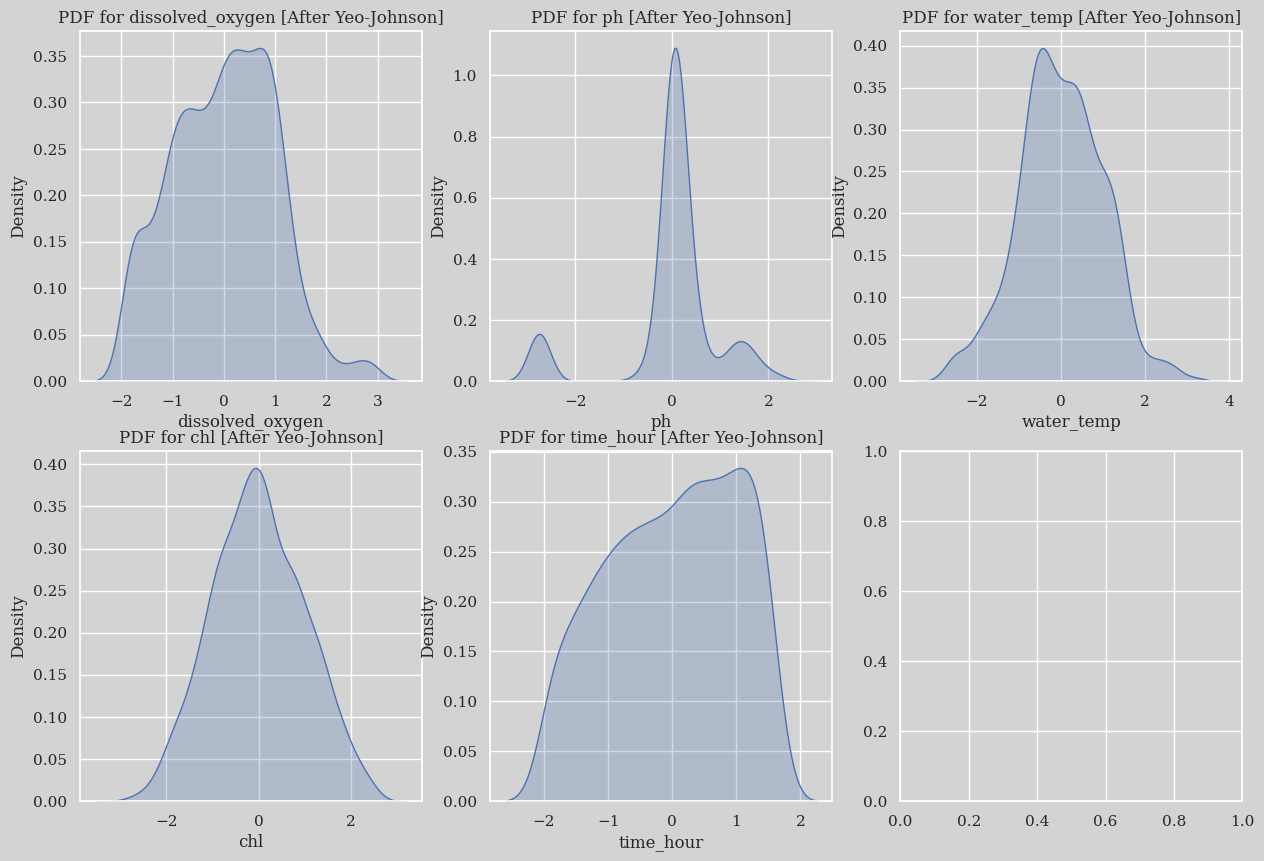

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = new_df.columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(new_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col} [After Yeo-Johnson]")

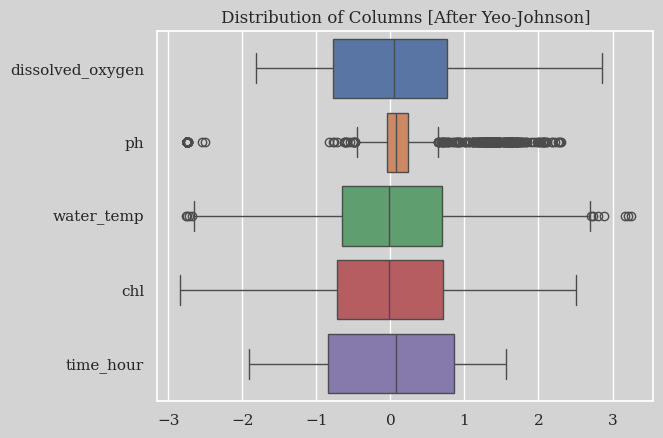

In [ ]:
sns.boxplot(new_df, orient="h")
plt.title("Distribution of Columns [After Yeo-Johnson]");

There we go! Not only Yeo-Johnson makes the distribution Normal but it also lessen the outliers! 

But there's still some work to do for there are still outliers.

Our focus now shall be the `water_temp` and `ph`.

And how to mitigate them effects.

In [ ]:
def detect_outliers(data, mult=1.5, normalized=True):
    '''Count the outliers using iqr'''
    lower, upper = data.quantile([0.25,0.75])

    iqr = upper - lower

    lower_bound, upper_bound = lower - iqr*mult, upper + iqr*mult

    outliers = len(data) - (data.between(lower_bound, upper_bound)).sum()
    if not normalized:
        return outliers
    else:
        return outliers / len(data)

In [ ]:
new_df.apply(detect_outliers, axis=0) 

dissolved_oxygen    0.000000
ph                  0.235904
water_temp          0.007129
chl                 0.000000
time_hour           0.000000
dtype: float64

#### Correlation

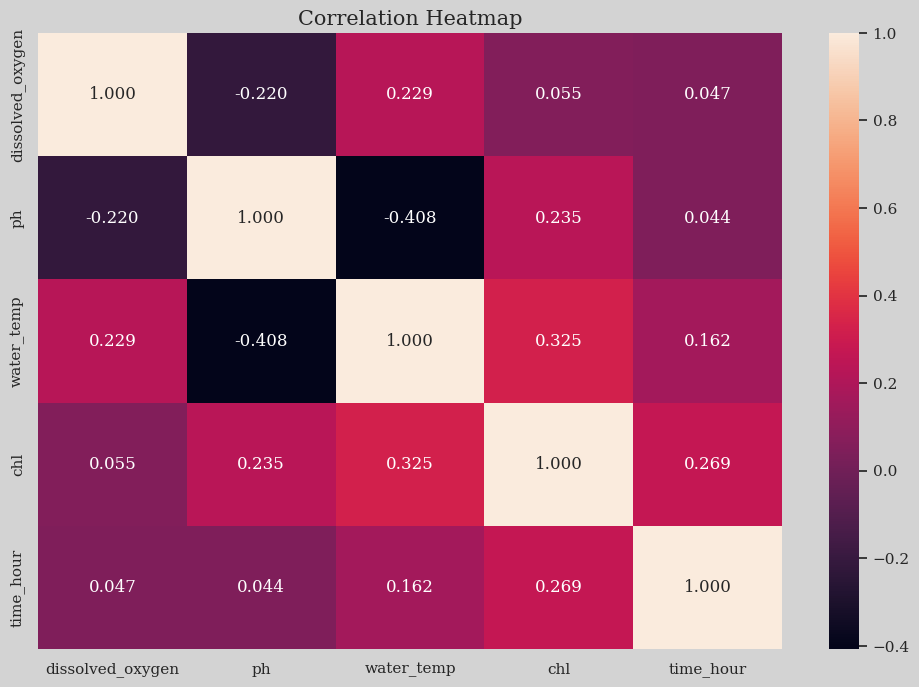

In [ ]:

corr = new_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".3f"
)

plt.title("Correlation Heatmap", size=15);

#### Patterns

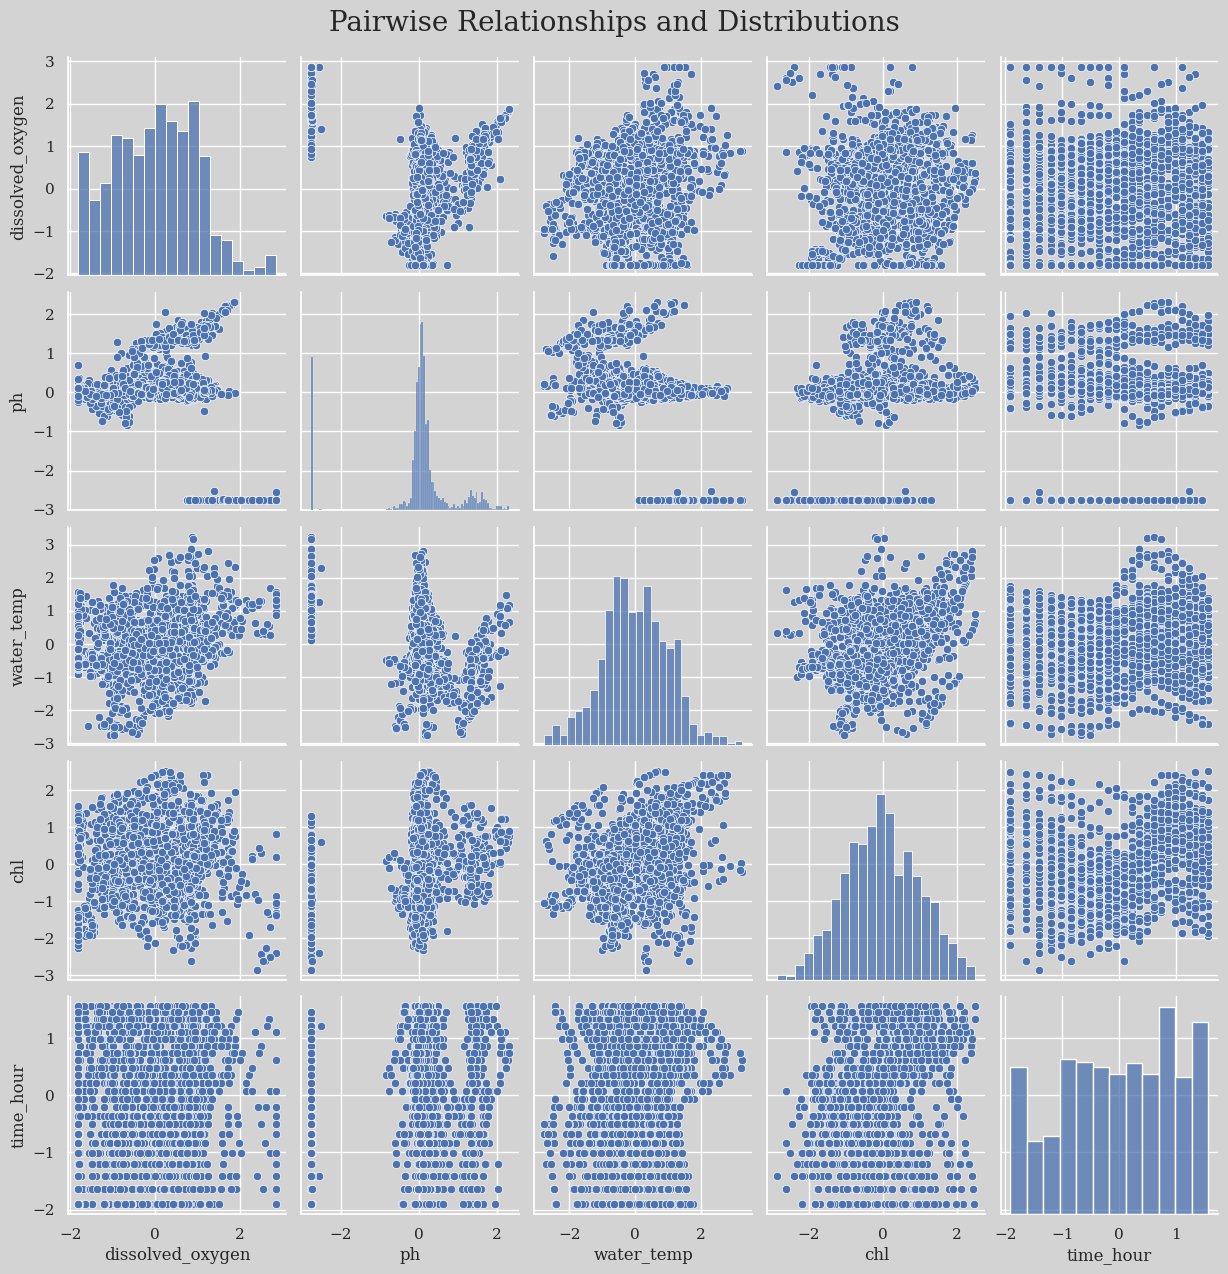

In [ ]:
g = sns.pairplot(new_df)


g.figure.suptitle("Pairwise Relationships and Distributions", y=1.02, size=20)

plt.show();


If we look at the column of `ph`, it appears that there's a large gap between the  outliers and the mean. This could be an error in measurement(?)

In [ ]:
samp = new_df['ph'].value_counts(normalize=True).reset_index()
samp[samp['ph'] < -2].sum()['proportion']

0.09008425145819834

9% are -2 or below!

In [ ]:
samp = pd.concat([new_df, filtered_df['sample_date_int']],axis=1)

In [ ]:
formula = "chl ~ " + " + ".join([col for col in samp.columns  if col != "chl"])
lmlm = ols(formula, data=samp)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     104.3
Date:                Sat, 03 May 2025   Prob (F-statistic):           6.27e-92
Time:                        21:59:47   Log-Likelihood:                -1545.6
No. Observations:                1244   AIC:                             3103.
Df Residuals:                    1238   BIC:                             3134.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.2799     22.531      0.323      0.747     -36.922      51.482
dissolved_oxygen     0.0200      0.025      0.803      0.422      -0.029       0.069
ph                   0.4201      0.027     15.758      0.000       0.368       0.472
water_temp           0.4572      0.027     16.881      0.000       0.404       0.510
time_hour            0.1889      0.024      7.793      0.000       0.141       0.236
sample_date_int  -4.367e-07   1.35e-06     -0.322      0.747   -3.09e-06    2.22e-06
==============================================================================
Omnibus:                       14.539   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.883
Skew:                           0.076   Prob(JB):                      0.00715
Kurtosis:                       2.591   Cond. No.                     1.57e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So it appears that `ph`, `water_temp`, and `time_hour` are good indicator based on their p-values. On the other hand, `sample_date_int` and `dissolved_oxygen` aren't significant indicator.

Adj R-Sq square improved by about 4% compared to the original dataset but I don't think that's enough.

But the most noticable improvement is in BIC and AIC that was reduced by about 5000! BIC and AIC should be lower so that's a good sign.

In [ ]:
formula = "chl ~ " + " + ".join([col for col in samp.drop(columns=['sample_date_int', 'dissolved_oxygen']).columns  if col != "chl"])
lmlm = ols(formula, data=samp)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     217.0
Date:                Sat, 03 May 2025   Prob (F-statistic):          2.31e-117
Time:                        21:59:47   Log-Likelihood:                -1917.3
No. Observations:                1543   AIC:                             3843.
Df Residuals:                    1539   BIC:                             3864.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.674e-17      0.021  -4.06e-15      1.000      -0.042       0.042
ph             0.4179      0.024     17.723      0.000       0.372       0.464
water_temp     0.4670      0.024     19.563      0.000       0.420       0.514
time_hour      0.1753      0.022      8.034      0.000       0.132       0.218
==============================================================================
Omnibus:                       18.068   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.242
Skew:                           0.078   Prob(JB):                      0.00220
Kurtosis:                       2.593   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using only the three significant columns increases the R-Squeared by 0.003 but does worsen the BIC and AIC by large amount so that's not good.

Note for next session:
* Should I revert the transformation on dependent (`chl`) for scale purposes when eveluating the df_test
* What to do with outliers.
* Feature engineering
* Consider binning the `ph` to flag outliers.
* Consider also using regularization (although this might not be needed given the small coefs)

---

## Feature Engineering

**Future Romand Here**: This is useless section. You can skip ahead

In [ ]:
new_df

,dissolved_oxygen,ph,water_temp,chl,time_hour
0,-1.794564,0.104626,0.137189,0.354699,-0.670928
1,0.638491,1.245186,-0.598758,-0.112043,-1.410903
2,-0.078968,1.282553,-1.530630,-0.586223,-1.410903
3,0.060495,0.047437,-0.245048,-0.379805,-0.060585
4,0.882023,-2.752801,1.771080,-1.433355,0.610507
...,...,...,...,...,...
1538,-0.397576,0.221673,-0.775673,-0.400565,1.447552
1539,0.624037,0.056907,1.259177,0.982158,1.100301
1540,-0.323950,-0.055136,0.133104,0.323330,0.351336
1541,-1.811986,-0.100801,-0.650216,-1.420166,-1.907685


In [ ]:
date_time = df[['sample_date', 'time']].copy()
date_time['sample_date_dt'] = pd.to_datetime(date_time['sample_date'], errors='coerce')

date_time['time_td'] = pd.to_timedelta(date_time['time'], errors='coerce')
date_time['combined_datetime'] = date_time['sample_date_dt'] + date_time['time_td']

new_df['datetime'] = date_time.combined_datetime



In [ ]:
new_df.sort_values(by="datetime", inplace=True)

In [ ]:
date_chl = new_df[['datetime', 'chl']].set_index("datetime")
new_df_copy = new_df.copy()
for n in range(1,11):
    new_df_copy[f'ma_{n}'] = new_df_copy['chl'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

<Axes: >

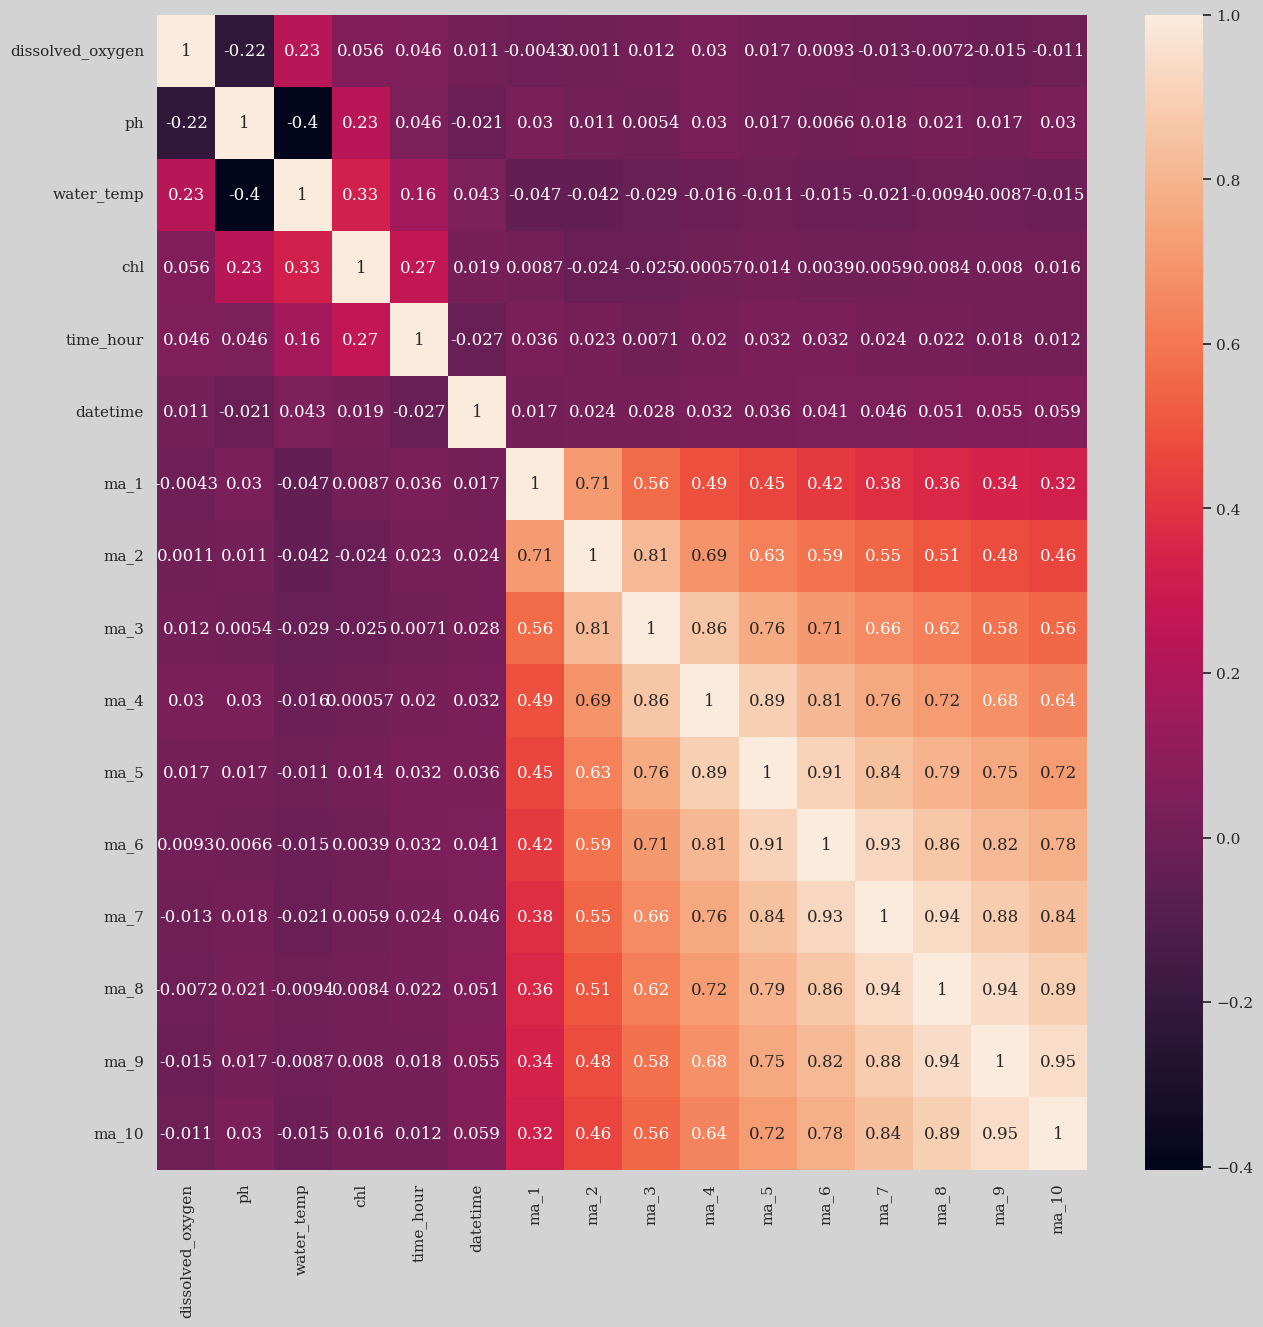

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(new_df_copy.corr(), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.245960
time_hour           0.229512
ph                  0.180154
dissolved_oxygen    0.139627
ma_1                0.030416
ma_3                0.022303
ma_4                0.022080
ma_2                0.021354
ma_10               0.021198
ma_9                0.019303
ma_8                0.019101
ma_6                0.017798
ma_5                0.017052
ma_7                0.014143
dtype: float64


In [ ]:
cols_to_drop = [f"ma_{n}" for n in range(6,10)]

X = new_df_copy.drop(columns=["chl", 'datetime'] + cols_to_drop)
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.253479
time_hour           0.233839
ph                  0.187038
dissolved_oxygen    0.149422
ma_1                0.035907
ma_10               0.035031
ma_4                0.027869
ma_3                0.026853
ma_5                0.025304
ma_2                0.025258
dtype: float64


<Axes: >

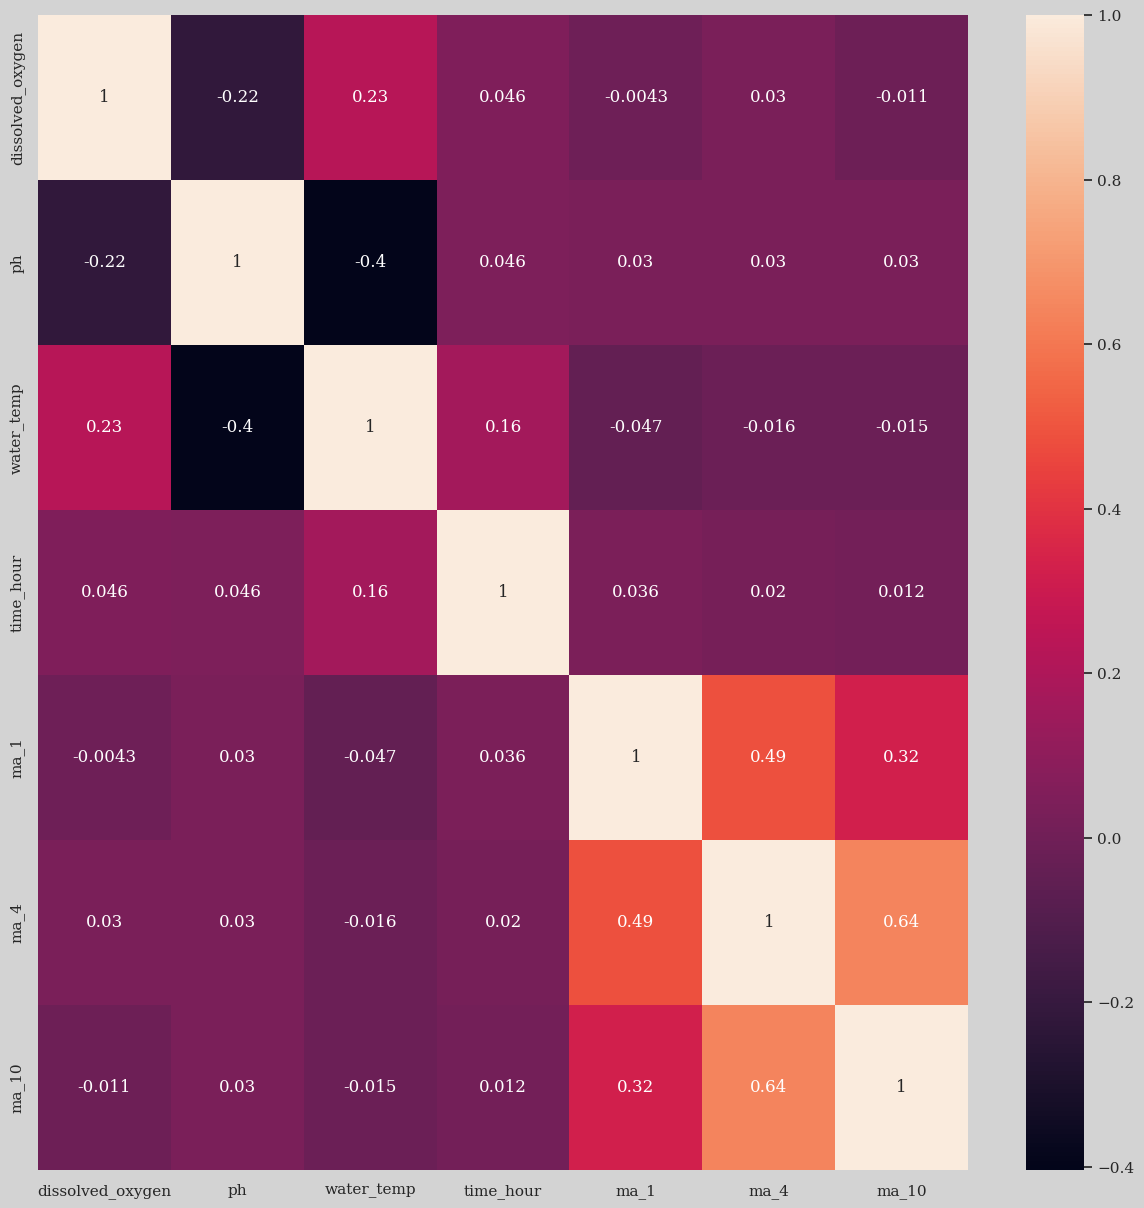

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(new_df_copy.drop(columns=["chl", 'datetime', 'ma_3', 'ma_2', 'ma_5'] + cols_to_drop).corr(), annot=True)

In [ ]:
X = new_df_copy.drop(columns=["chl", 'datetime', 'ma_3', 'ma_2', 'ma_5'] + cols_to_drop)
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.264884
time_hour           0.240367
ph                  0.198244
dissolved_oxygen    0.163492
ma_1                0.048101
ma_10               0.043529
ma_4                0.041382
dtype: float64


So we just need to calculate for ma_1, ma_10, ma_4. Although, I think this doesn't contribute much but we'll see.

In [ ]:
date_chl = new_df[['datetime', 'chl']].set_index("datetime")
new_df_copy = new_df.copy()

ma_n = [1,4,10]
for n in ma_n:
    new_df_copy[f'ma_{n}'] = new_df_copy['chl'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

In [ ]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)

regularization_alpha = 0.1

results_lasso = lmlm.fit_regularized(method='elastic_net', L1_wt=1, alpha=regularization_alpha)

print("Lasso Coefficients:")
print(results_lasso.params)

Lasso Coefficients:
Intercept           0.000000
dissolved_oxygen    0.000000
ph                  0.256739
water_temp          0.316942
time_hour           0.103748
ma_1                0.000000
ma_4                0.000000
ma_10               0.000000
dtype: float64


In [ ]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     93.31
Date:                Sat, 03 May 2025   Prob (F-statistic):          2.16e-113
Time:                        21:59:55   Log-Likelihood:                -1901.6
No. Observations:                1533   AIC:                             3819.
Df Residuals:                    1525   BIC:                             3862.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0010      0.021     -0.048      0.962      -0.043       0.041
dissolved_oxygen     0.0367      0.022      1.649      0.099      -0.007       0.080
ph                   0.4216      0.024     17.650      0.000       0.375       0.468
water_temp           0.4655      0.024     19.208      0.000       0.418       0.513
time_hour            0.1700      0.022      7.756      0.000       0.127       0.213
ma_1                 0.0207      0.025      0.842      0.400      -0.028       0.069
ma_4                -0.0699      0.061     -1.139      0.255      -0.190       0.050
ma_10                0.0757      0.088      0.862      0.389      -0.097       0.248
==============================================================================
Omnibus:                       20.777   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.573
Skew:                           0.081   Prob(JB):                      0.00113
Kurtosis:                       2.568   Cond. No.                         5.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
date_chl = new_df[['datetime', 'water_temp']].set_index("datetime")
new_df_copy = new_df.copy()

ma_n = range(1,11)
for n in ma_n:
    new_df_copy[f'w_ma_{n}'] = new_df_copy['dissolved_oxygen'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

In [ ]:
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.245414
time_hour           0.229163
ph                  0.178579
dissolved_oxygen    0.140305
w_ma_1              0.027395
w_ma_2              0.024306
w_ma_3              0.020752
w_ma_7              0.020569
w_ma_6              0.019872
w_ma_10             0.019507
w_ma_5              0.019364
w_ma_4              0.019145
w_ma_8              0.018116
w_ma_9              0.017512
dtype: float64


In [ ]:
new_df_copy['datetime'].dt.dayofyear

10      223
11      223
12      223
13      223
14      223
       ... 
1538    294
1539    294
1540    294
1541    294
1542    294
Name: datetime, Length: 1533, dtype: int32

In [ ]:
new_df_copy = new_df.copy()
new_df_copy['day_of_week'] = new_df_copy['datetime'].dt.day
new_df_copy

,dissolved_oxygen,ph,water_temp,chl,time_hour,datetime,day_of_week
0,-1.794564,0.104626,0.137189,0.354699,-0.670928,2022-08-11 00:01:00,11
1,0.638491,1.245186,-0.598758,-0.112043,-1.410903,2022-08-11 01:01:00,11
2,-0.078968,1.282553,-1.530630,-0.586223,-1.410903,2022-08-11 02:01:00,11
3,0.060495,0.047437,-0.245048,-0.379805,-0.060585,2022-08-11 03:01:00,11
4,0.882023,-2.752801,1.771080,-1.433355,0.610507,2022-08-11 04:01:00,11
...,...,...,...,...,...,...,...
1538,-0.397576,0.221673,-0.775673,-0.400565,1.447552,2022-10-21 10:01:00,21
1539,0.624037,0.056907,1.259177,0.982158,1.100301,2022-10-21 11:01:00,21
1540,-0.323950,-0.055136,0.133104,0.323330,0.351336,2022-10-21 12:01:00,21
1541,-1.811986,-0.100801,-0.650216,-1.420166,-1.907685,2022-10-21 13:01:00,21


In [ ]:
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.288549
time_hour           0.249449
ph                  0.224944
dissolved_oxygen    0.184739
day_of_week         0.052319
dtype: float64


In [ ]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     131.0
Date:                Sat, 03 May 2025   Prob (F-statistic):          8.59e-116
Time:                        21:59:58   Log-Likelihood:                -1915.5
No. Observations:                1543   AIC:                             3843.
Df Residuals:                    1537   BIC:                             3875.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0453      0.049     -0.921      0.357      -0.142       0.051
dissolved_oxygen     0.0348      0.022      1.570      0.117      -0.009       0.078
ph                   0.4230      0.024     17.757      0.000       0.376       0.470
water_temp           0.4604      0.024     19.074      0.000       0.413       0.508
time_hour            0.1747      0.022      8.005      0.000       0.132       0.217
day_of_week          0.0028      0.003      1.023      0.307      -0.003       0.008
==============================================================================
Omnibus:                       20.662   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.734
Skew:                           0.089   Prob(JB):                      0.00104
Kurtosis:                       2.573   Cond. No.                         42.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So that doesn't work.

---

# Final Model

In [ ]:
formula = "chl ~ " + " + ".join([col for col in new_df.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     163.5
Date:                Sat, 03 May 2025   Prob (F-statistic):          1.06e-116
Time:                        21:59:59   Log-Likelihood:                -1916.1
No. Observations:                1543   AIC:                             3842.
Df Residuals:                    1538   BIC:                             3869.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.021e-17      0.021  -4.22e-15      1.000      -0.042       0.042
dissolved_oxygen     0.0351      0.022      1.583      0.114      -0.008       0.079
ph                   0.4234      0.024     17.774      0.000       0.377       0.470
water_temp           0.4613      0.024     19.126      0.000       0.414       0.509
time_hour            0.1743      0.022      7.990      0.000       0.132       0.217
==============================================================================
Omnibus:                       21.042   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.832
Skew:                           0.085   Prob(JB):                     0.000992
Kurtosis:                       2.569   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

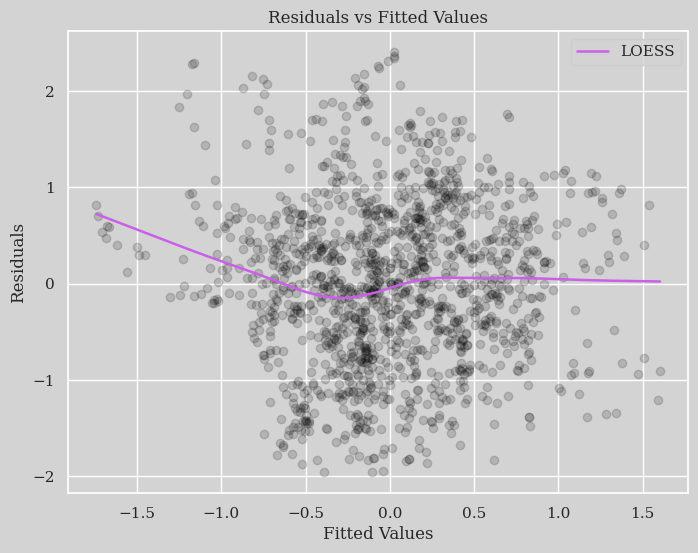

In [80]:
plt.figure(figsize=(8, 6))

sns.regplot(x=results.predict(), 
            y=results.resid, 
            scatter_kws={'alpha':0.15, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(results.resid.to_frame())
standardized_resid = scaler.transform(results.resid.to_frame()).squeeze()
standardized_resid_sorted = np.sort(standardized_resid)

normal_theo = np.sort(np.random.normal(0, 1, len(standardized_resid)));


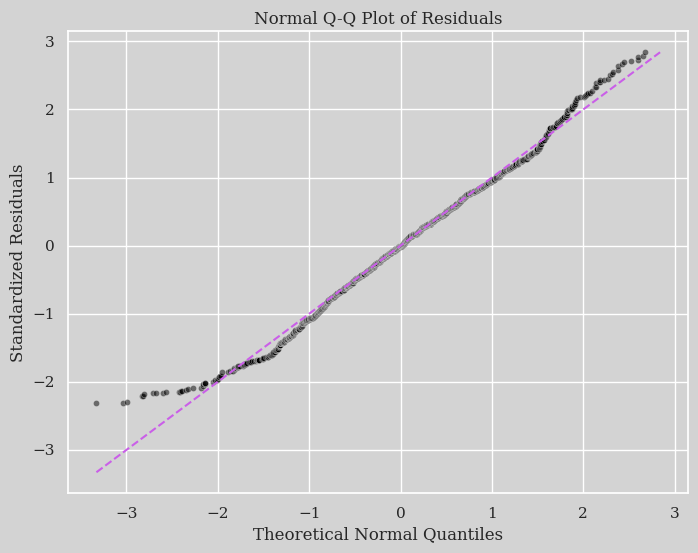

In [82]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

sns.scatterplot(x=normal_theo,
                y=standardized_resid_sorted,
                color="black",
                ax=ax,
                alpha=0.5,
                s=20)

line_coords = np.linspace(min(normal_theo), max(standardized_resid_sorted))

ax.plot(line_coords, line_coords, color='#ca5fe8', linestyle="--") 


ax.set_title('Normal Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical Normal Quantiles')
ax.set_ylabel('Standardized Residuals');



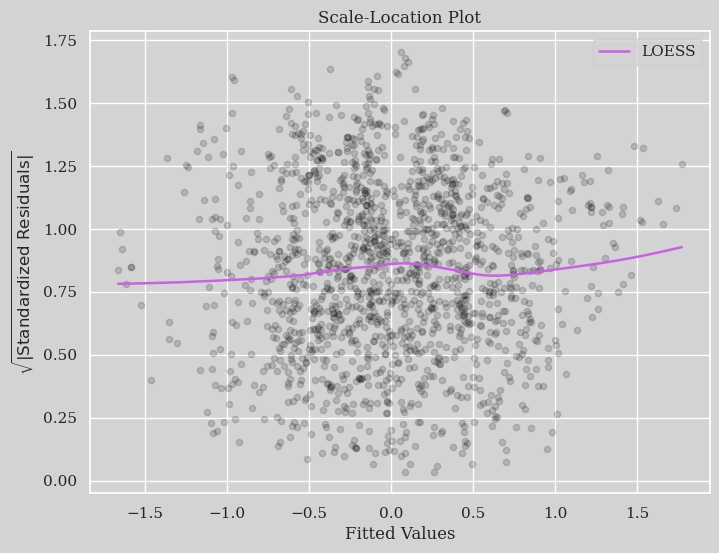

In [ ]:

abs_standardized_resid = np.abs(standardized_resid)
sqrt_abs_standardized_resid = np.sqrt(abs_standardized_resid)

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=results.predict(),
            y=sqrt_abs_standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Scale-Location Plot')
ax.set_xlabel('Fitted Values') 
ax.set_ylabel(r'$\sqrt{|\text{Standardized Residuals}|}$')

plt.legend()
plt.show()

In [ ]:
influence = results.get_influence()
leverage_values = influence.hat_matrix_diag

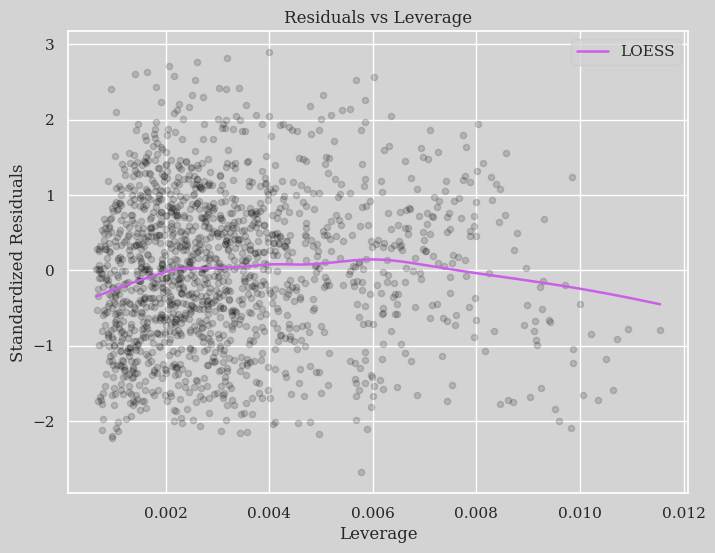

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=leverage_values,
            y=standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Residuals vs Leverage')
ax.set_ylabel('Standardized Residuals') 
ax.set_xlabel('Leverage')

plt.legend()
plt.show()

### Crooks distance

---

### Evaluation

In [ ]:
df_test

,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
1118,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-28,-1.1248,6.9518,29.1989,10:01:00,1.7545
1653,CCMS_BML,Bolinao,119.9252,16.38712,2022-10-26,-2.0992,6.8951,30.7062,7:01:00,2.2143
1864,CCMS_BML,Bolinao,119.9252,16.38712,2023-10-05,1.0065,0.3600,30.9297,10:01:00,1.8271
941,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-20,0.8576,6.9014,30.2870,23:01:00,6.9333
331,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-25,-1.9552,6.6746,27.5494,3:01:00,1.8634
...,...,...,...,...,...,...,...,...,...,...
567,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-05,-0.2896,7.5629,28.1369,5:01:00,8.0828
720,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-11,-1.5280,6.8636,32.1713,15:01:00,7.9618
1132,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-29,-0.8080,6.9707,29.4892,0:01:00,2.9282
979,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-22,1.5872,6.8888,30.1897,13:01:00,4.2955
